# Throughputs_LSSTobs_calspec

Based on Lynne Jones code here: https://rubin-obs.slack.com/archives/C0824CTA335/p1732311332938929

Created:  2024.11.27

Updated:  2025.10.06

## 1. Initial Setup...

### 1.1 Import useful python packages

In [1]:
# Generic python packages
import pylab as plt
import numpy as np
import pandas as pd
import glob
import math
import os
import gc
import warnings
from IPython.display import display

# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

# rubin_sim-related packages
import rubin_sim.phot_utils as pt
import syseng_throughputs as st
from rubin_sim.data import get_data_dir

# Astropy-related packages
from astropy import units as u
from astropy.io import fits
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.table import Table

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)
afwDisplay.setDefaultBackend('matplotlib')

# Use Rubin standardized colors/symbols/linestyles for u,g,r,i,z,y
from lsst.utils.plotting import (get_multiband_plot_colors,
                                 get_multiband_plot_symbols,
                                 get_multiband_plot_linestyles)

# Set filter warnings to "ignore" to avoid a lot of "logorrhea" to the screen:
warnings.filterwarnings("ignore")

/home/d/dltucker/WORK/GitHub/syseng_throughputs/syseng_throughputs/bandpassUtils.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### 1.2 Include user input

In [2]:
# Which repo, collection, instrument, and skymap to use.
# See https://rubinobs.atlassian.net/wiki/spaces/DM/pages/48834013/Campaigns#1.1.-ComCam
# and https://rubinobs.atlassian.net/wiki/spaces/DM/pages/226656354/LSSTComCam+Intermittent+Cumulative+DRP+Runs
#repo = '/repo/main'
#collections = 'LSSTComCam/DP1'

repo = '/repo/main'
collections = 'LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645'

#instrument = 'LSSTComCam'
#skymap_name = 'lsst_cells_v1'
#day_obs_start = 20241101
#day_obs_end = 20241231

instrument = 'LSSTCam'
skymap_name = 'lsst_cells_v1'
day_obs_start = 20250401
day_obs_end = 20251230

# Which flux to use?  psfFlux or calibFlux?
fluxName = 'psfFlux'
fluxerrName = 'psfFluxErr'
#fluxName = 'calibFlux'
#fluxerrName = 'calibFluxErr'


# Set environment variable to point to location of the rubin_sim_data 
#  (per Lynne Jones' Slack message on the #sciunit-photo-calib channel from 26 Nov 2024):
os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"

# CalSpec star name
star_name = 'C26202'

# Which CalSpec spectrum FITS file to to use?
sedfile = '~/Downloads/c26202_stiswfcnic_007.fits'
#sedfile = '~/Downloads/c26202_mod_007.fits'
#sedfile = '~/Downloads/c26202_stiswfcnic_006.fits'
#sedfile = '~/Downloads/c26202_mod_008.fits'
#sedfile = '~/Downloads/c26202_stiswfcnic_007.fits'

# RA, DEC of CalSpec star
raDeg = 53.136845833333325
decDeg = -27.86349444444444

# List of filters to examine
flist = ['u','g','r','i','z','y']

# Plot symbol colors to use for ugrizy
plot_filter_colors_white_background = {'u': '#0c71ff', 'g': '#49be61', 'r': '#c61c00', 'i': '#ffc200', 'z': '#f341a2', 'y': '#5d0000'}

# Variables controlling output...
verbose = 2         # verbose = 0, 1, 2, 3, ...  Higher numbers mean more output.
outputCSV = False    # output CSV files
# There was a major change in the DRP pipeline starting with w_2025_05.
# See:  https://rubin-obs.slack.com/archives/C07TXQUAXUZ/p1738795935921129
post_w_2025_04 = True

### 1.3 Define useful classes and functions

In [3]:
# Cartesian x,y match with error (per Claude-3.5-Sonnet)

def cartesianXYMatchWithError(df1, xcol1, ycol1, df2, xcol2, ycol2, sep_limit=1.0, allMatches=True):
    
    import numpy as np
    from scipy.spatial import cKDTree
    import pandas as pd

    # Create KD-tree for efficient spatial searching
    tree = cKDTree(df2[[xcol2, ycol2]])

    # Find nearest neighbors within sep_limit
    separations, indices = tree.query(df1[[xcol1, ycol1]],
                                  distance_upper_bound=sep_limit)

    # Create mask for valid matches (separations less than sep_limit)
    valid_matches = separations < sep_limit

    # Create merged dataframe using only valid matches
    merged_df = pd.concat([
        df1[valid_matches].reset_index(drop=True),
        df2.iloc[indices[valid_matches]].reset_index(drop=True)
        ], axis=1)

    # If you want to keep track of the match separations
    merged_df['separation'] = separations[valid_matches]

    # If you want to keep just the best match, sort by separation 
    # and keep first occurrence of each df2 index
    if allMatches != True:
        merged_df = merged_df.sort_values('separation').drop_duplicates(
            subset=df2.columns, keep='first'
        )

    return merged_df



In [4]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

### 1.4 Instantiate the butler and registry

In [5]:
butler = dafButler.Butler(repo, collections=collections)
registry = butler.registry

## 2. Estimate expected counts for airmasses X=1.0 to 2.5

### 2.1 Build the hardware and system for ugrizy for Cerro Pachon for airmasses X=1.0-2.5 in steps of 0.1 airmass

In [6]:
# From https://github.com/lsst-pst/syseng_throughputs/blob/main/notebooks/InterpolateZeropoint.ipynb

defaultDirs = st.setDefaultDirs()
if instrument == "LSSTComCam":
    #Change detectors from (default) LSST to ComCam (ITL CCDs)
    defaultDirs['detector'] = defaultDirs['detector'].replace('/joint_minimum', '/itl')

airmasses = np.arange(1.0, 2.6, 0.1).round(2)

system = {}
for x in airmasses:
    #atmos files temporarily inaccessible from /sdf/data/rubin/shared/rubin_sim_data/throughputs/atmos;
    # using a temporary solution here:
    #atmos = st.readAtmosphere(os.path.join(get_data_dir(), 'throughputs', 'atmos'), atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
    atmosDir = '/home/d/dltucker/DATA/rubin_sim_data_throughputs/throughputs/atmos'
    atmos = st.readAtmosphere(atmosDir, atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
    h, s = st.buildHardwareAndSystem(defaultDirs, addLosses=True,  atmosphereOverride=atmos)
    system[x] = s
hardware = h


### 2.2 Plot filter passbands (without the atmospheric component) and the atmospheric transmission for airmasses 1.0, 1.2, 2.0

In [7]:
# From https://github.com/lsst-pst/syseng_throughputs/blob/main/notebooks/InterpolateZeropoint.ipynb

# Plot only if verbosity level is higher than 2...
if verbose > 2:
    
    colors = plot_filter_colors_white_background
    for f in flist:
        plt.plot(hardware[f].wavelen, hardware[f].sb, color=colors[f], linestyle=':')
    for x in [1.0, 1.2, 2.0]:
        #atmos files temporarily inaccessible from /sdf/data/rubin/shared/rubin_sim_data/throughputs/atmos;
        # using a temporary solution here:
        #atmos = st.readAtmosphere(os.path.join(get_data_dir(), 'throughputs', 'atmos'), atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
        atmosDir = '/home/d/dltucker/DATA/rubin_sim_data_throughputs/throughputs/atmos'
        atmos = st.readAtmosphere(atmosDir, atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
        plt.plot(atmos.wavelen, atmos.sb, linestyle='-')
    plt.ylim(0, 1)
    plt.xlim(300, 1100)
    plt.xlabel("Wavelength (nm)")


### 2.3 Read in the CalSpec SED file and translate it into `rubin_sim` format 

In [8]:
# Read the sedfile file 
seddata = fits.getdata(sedfile)

# Translate to rubin_sim format
wavelen = seddata['WAVELENGTH'] * u.angstrom.to(u.nanometer) # This is in angstroms - need in nanometers
flambda = seddata['FLUX'] / (u.angstrom.to(u.nanometer)) # this is in erg/sec/cm^^2/ang but we want /nm 

# Convert to rubin_sim format
sed = pt.Sed(wavelen=wavelen, flambda=flambda)

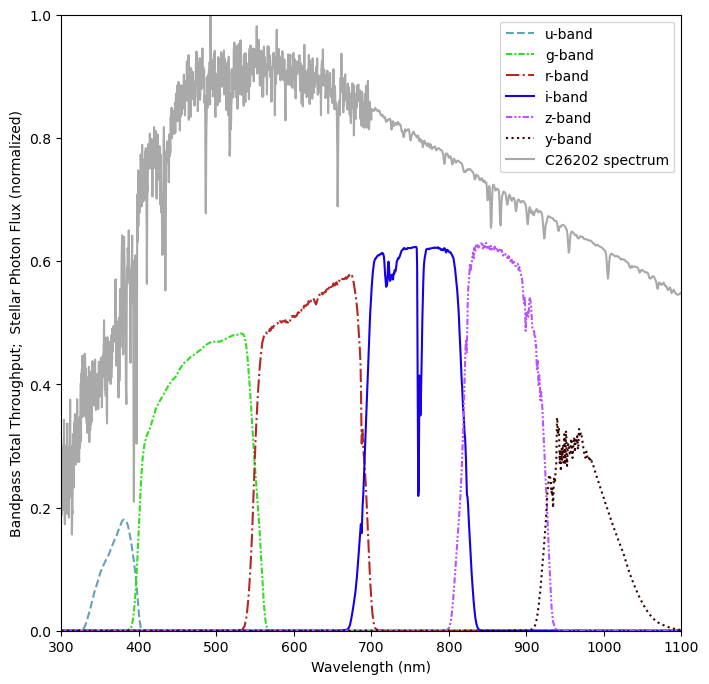

In [9]:
# Plot star spectrum (in normalized photon flux) with filter passbands

filter_colors = get_multiband_plot_colors()
filter_symbols = get_multiband_plot_symbols()
filter_linestyles = get_multiband_plot_linestyles()

x = 1.2
atmos = st.readAtmosphere(atmosDir, atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')

# Create empty list to store legend handles
legend_handles = []

for f in flist:
    # Store the line handle when plotting
    line, = plt.plot(hardware[f].wavelen, hardware[f].sb*atmos.sb, 
                    color=filter_colors[f], 
                    linestyle=filter_linestyles[f],
                    label=f'{f}-band')  # Add label for each filter
    legend_handles.append(line)

# Constants
h = 6.626e-34  # Planck constant in J*s
c = 2.998e8    # Speed of light in m/s

# Calculate photon flux
wavelen_m = wavelen * 1e-9
flambda_joules = flambda * 1e-7
fphoton = flambda_joules * wavelen_m / (h * c)

# Store the stellar flux line handle
label = """%s spectrum""" % (star_name)
stellar_line, = plt.plot(wavelen, fphoton/max(fphoton), 
                        color='darkgrey', 
                        linestyle='-',
                        label=label)
legend_handles.append(stellar_line)

plt.xlim([300., 1100.])
plt.ylim([0.0, 1.0])
plt.xlabel("Wavelength (nm)")
plt.ylabel("Bandpass Total Throughput;  Stellar Photon Flux (normalized)")

# Add the legend
plt.legend(handles=legend_handles, loc='upper right')

### 2.4 Define the photometric parameters to use.

In [10]:
phot_params = pt.PhotometricParameters(exptime=30, nexp=1, gain=1.0)


### 2.5 Calculate the expected counts for CalSpec star for the given photometric parameters over the airmass range of X=1.0-2.5

First, calculate the expected counts using the standard 30-second exposure time...

In [11]:
counts = {}
for f in flist:
    counts[f] = []
    for x in airmasses:
        counts[f].append(sed.calc_adu(system[x][f], phot_params))
    counts[f] = np.array(counts[f])


In [12]:
df_counts = pd.DataFrame(counts, index=airmasses)

if verbose > 0:
    display(df_counts)

,u,g,r,i,z,y
1.0,113903.105869,1.595908e+06,1.890467e+06,1.744171e+06,1.237520e+06,511370.756317
1.1,109275.963042,1.566471e+06,1.869171e+06,1.731662e+06,1.230557e+06,506026.651139
1.2,104807.807923,1.537421e+06,1.848023e+06,1.719303e+06,1.223682e+06,500876.179554
1.3,100591.008964,1.509309e+06,1.827389e+06,1.707290e+06,1.216981e+06,495993.849469
1.4,96523.963684,1.481599e+06,1.806919e+06,1.695410e+06,1.210361e+06,491263.396427
1.5,92605.673422,1.454303e+06,1.786604e+06,1.683664e+06,1.203814e+06,486671.720496
1.6,88903.509226,1.427871e+06,1.766785e+06,1.672193e+06,1.197413e+06,482291.964516
1.7,85272.693235,1.401409e+06,1.746835e+06,1.660711e+06,1.191004e+06,477955.867712
1.8,81823.590867,1.375675e+06,1.727279e+06,1.649434e+06,1.184714e+06,473778.556891
1.9,78675.598249,1.351499e+06,1.708712e+06,1.638668e+06,1.178680e+06,469887.749645


### 2.6 Output results to CSV file

In [13]:
if outputCSV:
    if instrument == "LSSTComCam":
        outputFile = 'LSSTComCam_calspec_expected_counts.csv'
    else:
        outputFile = 'LSSTCam_calspec_expected_counts.csv'

    df_counts.to_csv(outputFile)  #  Here, we want to keep the index for the DataFrame, which, in this case, is the airmass

## 3. Query USDF Butler for ComCam exposures

### 3.1 Create query

In [14]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Build WHERE clause
where = f"instrument='{instrument}' AND day_obs>={day_obs_start} AND day_obs<={day_obs_end}"

# Query all exposure records in one go
results = list(registry.queryDimensionRecords("exposure", where=where))



### 3.2 Check that there are results; stop execution if there are none

In [15]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Stop executing if there are no results returned:

n_results = len(results)
if n_results == 0:
    raise StopExecution
else:
    print(f"There are {n_results} results returned from querying the butler for instrument {instrument} "
          f"between dates {day_obs_start} and {day_obs_end} (inclusive).")


There are 84464 results returned from querying the butler for instrument LSSTCam between dates 20250401 and 20251230 (inclusive).


### 3.3 Extract all rows into a list of tuples

In [16]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

rows = []
for info in results:
    try:
        rows.append((
            info.id,
            info.obs_id,
            info.day_obs,
            info.seq_num,
            info.timespan.begin,
            info.timespan.end,
            info.observation_type,
            info.observation_reason,
            info.target_name,
            info.physical_filter,
            info.zenith_angle,
            info.exposure_time,
            info.tracking_ra,
            info.tracking_dec,
            info.sky_angle,
            info.azimuth,
            info.zenith_angle,
            info.science_program
        ))
    except Exception as e:
        # Fallback values if timespan is missing or broken
        rows.append((
            info.id,
            info.obs_id,
            info.day_obs,
            info.seq_num,
            pd.to_datetime("2021-01-01 00:00:00.00"),
            pd.to_datetime("2051-01-01 00:00:00.00"),
            info.observation_type,
            info.observation_reason,
            info.target_name,
            info.physical_filter,
            info.zenith_angle,
            info.exposure_time,
            info.tracking_ra,
            info.tracking_dec,
            info.sky_angle,
            info.azimuth,
            info.zenith_angle,
            info.science_program
        ))


### 3.4 Build DataFrame in one shot

In [17]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

df_exp = pd.DataFrame(rows, columns=[
    'id', 'obs_id', 'day_obs', 'seq_num',
    'time_start', 'time_end', 'type', 'reason',
    'target', 'filter', 'zenith_angle',
    'expos', 'ra', 'dec', 'skyangle',
    'azimuth', 'zenith', 'science_program'
])

# Display current version of df_exp
#df_exp

### 3.5 Clean up DataFrame

In [18]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Compute JD and MJD vectorized
t_start = Time(df_exp['time_start'].tolist(), scale='tai')
df_exp['jd'] = t_start.jd
df_exp['mjd'] = t_start.mjd


In [19]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Re-cast the `id`, `day_obs`, and `seq_num` rows as `int`'s:
df_exp = df_exp.astype({"id": int,'day_obs': int,'seq_num':int})

In [20]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Replace `NaN`'s in the `ra` and `dec` columns with zero.  
# (`NaN`'s in `ra`, `dec` wreak havoc for the healpix tools defined in Section 1.2 above.) 
# ***(Maybe no longer necessary?)***

df_exp['ra'] = df_exp['ra'].fillna(0)
df_exp['dec'] = df_exp['dec'].fillna(0)

In [21]:
df_exp

,id,obs_id,day_obs,seq_num,time_start,time_end,type,reason,target,filter,zenith_angle,expos,ra,dec,skyangle,azimuth,zenith,science_program,jd,mjd
0,2025040400003,MC_C_20250404_000003,20250404,3,2460770.0975570185,2460770.097730822,dark,dark,UNKNOWN,unknown,NaN,15.0,0.000000,0.000000,NaN,NaN,NaN,unknown,2.460770e+06,60769.597557
1,2025040400006,MC_C_20250404_000006,20250404,6,2460770.0981735354,2460770.0983473263,dark,dark,UNKNOWN,unknown,NaN,15.0,0.000000,0.000000,NaN,NaN,NaN,unknown,2.460770e+06,60769.598174
2,2025040400001,MC_C_20250404_000001,20250404,1,2460770.097147471,2460770.0973212617,dark,dark,UNKNOWN,unknown,NaN,15.0,0.000000,0.000000,NaN,NaN,NaN,unknown,2.460770e+06,60769.597147
3,2025040400002,MC_C_20250404_000002,20250404,2,2460770.0973539185,2460770.0975277084,dark,dark,UNKNOWN,unknown,NaN,15.0,0.000000,0.000000,NaN,NaN,NaN,unknown,2.460770e+06,60769.597354
4,2025040400004,MC_C_20250404_000004,20250404,4,2460770.0977622764,2460770.097936065,dark,dark,UNKNOWN,unknown,NaN,15.0,0.000000,0.000000,NaN,NaN,NaN,unknown,2.460770e+06,60769.597762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84459,2025060900560,MC_O_20250609_000560,20250609,560,2460836.804555192,2460836.8049133914,science,field_survey_science,Rubin_SV_320_-15,z_20,29.711753,30.0,322.864727,-12.356219,142.872127,58.288757,29.711753,BLOCK-365,2.460837e+06,60836.304555
84460,2025060900562,MC_O_20250609_000562,20250609,562,2460836.805554494,2460836.8059130325,science,field_survey_science,Rubin_SV_320_-15,z_20,24.374480,30.0,318.225485,-14.938499,140.453584,55.390277,24.374480,BLOCK-365,2.460837e+06,60836.305554
84461,2025060900567,MC_O_20250609_000567,20250609,567,2460836.808133254,2460836.8084914465,science,field_survey_science,Rubin_SV_320_-15,z_20,27.657473,30.0,322.040534,-13.131164,136.223682,56.636817,27.657473,BLOCK-365,2.460837e+06,60836.308133
84462,2025060900569,MC_O_20250609_000569,20250609,569,2460836.8091218485,2460836.8094800464,science,field_survey_science,Rubin_SV_320_-15,z_20,22.351916,30.0,317.385345,-15.712581,133.860306,53.263396,22.351916,BLOCK-365,2.460837e+06,60836.309122


### 3.6 Add airmass to DataFrame

In [22]:
# Add an airmass to df_exp...

df_exp['airmass'] = np.round(1./np.cos(np.deg2rad(df_exp['zenith_angle'])), decimals=3)

In [23]:
# Printout zenith angle and airmass if verbosity level is greater than 1...
if verbose > 1:
    display(df_exp[['zenith_angle','airmass']])

,zenith_angle,airmass
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
84459,29.711753,1.151
84460,24.374480,1.098
84461,27.657473,1.129
84462,22.351916,1.081


### 3.7 Extract just "science" exposures

In [24]:
# Create a `DataFrame` containing just the science exposures:
df_sci = df_exp[df_exp.type == 'science']

In [25]:
# Look at columns for the (exposure/visit) id, zenith_angle, and airmass, 
#  but only if verbosity level is greater than 1:
if verbose > 1:
    display(df_sci[['id', 'zenith_angle','airmass']])

,id,zenith_angle,airmass
2008,2025041201041,37.715703,1.264
2009,2025041201042,33.591132,1.200
2010,2025041201043,39.249548,1.291
2358,2025041300381,38.223392,1.273
2359,2025041300443,32.973360,1.192
...,...,...,...
84459,2025060900560,29.711753,1.151
84460,2025060900562,24.374480,1.098
84461,2025060900567,27.657473,1.129
84462,2025060900569,22.351916,1.081


### 3.8 Remove any exposures in the "bad visit" list

#### 3.8.1 Read in "bad visit" list

In [26]:
if instrument == "LSSTComCam":
    df_bad_visits=Table.read("https://raw.githubusercontent.com/lsst-dm/excluded_visits/refs/heads/main/LSSTComCam/bad.ecsv").to_pandas()
    #df_bad_visits.rename(columns={'exposure': 'visit'}, inplace=True)
else: 
    df_bad_visits=Table.read("https://raw.githubusercontent.com/lsst-dm/excluded_visits/refs/heads/main/LSSTCam/bad.ecsv").to_pandas()

# Look at bad visits table, but only if verbosity level is greater than 0:
if verbose > 0:
    display(df_bad_visits)

,exposure,comment
0,2025041700761,tracking stopped
1,2025041800615,trailed
2,2025042000501,trailed
3,2025042300237,trailed
4,2025042500457,messy PSF
...,...,...
344,2025082800177,donuts
345,2025082800178,donuts
346,2025090300314,lights on
347,2025092100042,trailed


#### 3.8.2 Remove from df_sci any exposures found in df_bad_visits

In [27]:
df_sci = df_sci[~df_sci['id'].isin(df_bad_visits['exposure'])]


In [28]:
# Look at columns for the (exposure/visit) id, zenith_angle, and airmass, 
#  but only if verbosity level is greater than 0:
if verbose > 0:
    display(df_sci[['id', 'zenith_angle','airmass']])

,id,zenith_angle,airmass
2008,2025041201041,37.715703,1.264
2009,2025041201042,33.591132,1.200
2010,2025041201043,39.249548,1.291
2358,2025041300381,38.223392,1.273
2359,2025041300443,32.973360,1.192
...,...,...,...
84459,2025060900560,29.711753,1.151
84460,2025060900562,24.374480,1.098
84461,2025060900567,27.657473,1.129
84462,2025060900569,22.351916,1.081


### 3.9 Save results as a CSV file

In [29]:
if outputCSV:
    if instrument == "LSSTComCam":
        outputFile = """LSSTComCam_visits_%d-%d.csv""" % (day_obs_start, day_obs_end)
    else:
        outputFile = """LSSTCam_visits_%d-%d.csv""" % (day_obs_start, day_obs_end)
    df_sci.to_csv(outputFile, index=False)

### 3.10 Create a Pandas DataFrame from df_sci that just contains the visit id, exposure time, zenith angle, and airmass

In [30]:
df_sci_airmass = df_sci[['id', 'expos', 'zenith_angle','airmass']].copy(deep=True)
df_sci_airmass.reset_index(drop=True, inplace=True)

# Look at pandas dataframe, but only if verbosity level is greater than 0:
if verbose > 0:
    display(df_sci_airmass)

,id,expos,zenith_angle,airmass
0,2025041201041,30.0,37.715703,1.264
1,2025041201042,30.0,33.591132,1.200
2,2025041201043,30.0,39.249548,1.291
3,2025041300381,30.0,38.223392,1.273
4,2025041300443,30.0,32.973360,1.192
...,...,...,...,...
23423,2025060900560,30.0,29.711753,1.151
23424,2025060900562,30.0,24.374480,1.098
23425,2025060900567,30.0,27.657473,1.129
23426,2025060900569,30.0,22.351916,1.081


## 4. Query USDF Butler for ComCam measurements of CalSpec star

### 4.1 Find the `dataId`'s for all `visit_image`'s in this repo/collection that overlap the sky position of CalSpec star:

In [31]:
datasetRefs = butler.query_datasets("visit_image", where="visit_detector_region.region OVERLAPS POINT(ra, dec)",
                                    bind={"ra": raDeg, "dec": decDeg})

for i, ref in enumerate(datasetRefs):    
    print(i, ref.dataId)
    if ((verbose < 2) & (i >= 10)): 
        print("...")
        break


print(f"\nFound {len(datasetRefs)} visit_images")

0 {instrument: 'LSSTCam', detector: 44, visit: 2025090600260, band: 'z', day_obs: 20250906, physical_filter: 'z_20'}
1 {instrument: 'LSSTCam', detector: 49, visit: 2025090600252, band: 'z', day_obs: 20250906, physical_filter: 'z_20'}
2 {instrument: 'LSSTCam', detector: 51, visit: 2025090600256, band: 'z', day_obs: 20250906, physical_filter: 'z_20'}
3 {instrument: 'LSSTCam', detector: 51, visit: 2025090600266, band: 'z', day_obs: 20250906, physical_filter: 'z_20'}
4 {instrument: 'LSSTCam', detector: 51, visit: 2025090600280, band: 'r', day_obs: 20250906, physical_filter: 'r_57'}
5 {instrument: 'LSSTCam', detector: 52, visit: 2025082600442, band: 'i', day_obs: 20250826, physical_filter: 'i_39'}
6 {instrument: 'LSSTCam', detector: 52, visit: 2025082600445, band: 'i', day_obs: 20250826, physical_filter: 'i_39'}
7 {instrument: 'LSSTCam', detector: 52, visit: 2025090600254, band: 'z', day_obs: 20250906, physical_filter: 'z_20'}
8 {instrument: 'LSSTCam', detector: 52, visit: 2025090600259, ba

### 4.2 Create a pandas Dataframe containing the `recalibrated_star_detector` (formerly `sourceTable`) info for all these `(preliminary_)visit_image`'s

#### 4.2.1 Loop over the `datasetRefs` again, grabbing the contents of the `recalibrated_star_detector` table for each `ref` and combining into all into one big pandas DataFrame.  

In [32]:
src_list = []

for i, ref in enumerate(datasetRefs):
    
    # Retrieve sourceTable for this visit & detector...
    dataId = {'visit': ref.dataId['visit'], 'detector': ref.dataId['detector']}
    src = butler.get('recalibrated_star_detector', dataId=dataId)
    src_list.append(src.to_pandas())

    if ((verbose >= 2) | (i < 10)): 
        print(f"{i} Visit {ref.dataId['visit']}, Detector {ref.dataId['detector']}:  Retrieved catalog of {len(src)} sources.")
    if ((verbose < 2) & (i == 10)): 
        print("...")

src_all = pd.concat(src_list, ignore_index=True)

print("")
print(f"Total combined catalog contains {len(src_all)} sources.")


0 Visit 2025090600260, Detector 44:  Retrieved catalog of 953 sources.
1 Visit 2025090600252, Detector 49:  Retrieved catalog of 587 sources.
2 Visit 2025090600256, Detector 51:  Retrieved catalog of 943 sources.
3 Visit 2025090600266, Detector 51:  Retrieved catalog of 1093 sources.
4 Visit 2025090600280, Detector 51:  Retrieved catalog of 499 sources.
5 Visit 2025082600442, Detector 52:  Retrieved catalog of 2478 sources.
6 Visit 2025082600445, Detector 52:  Retrieved catalog of 2514 sources.
7 Visit 2025090600254, Detector 52:  Retrieved catalog of 913 sources.
8 Visit 2025090600259, Detector 52:  Retrieved catalog of 889 sources.
9 Visit 2025090600253, Detector 53:  Retrieved catalog of 727 sources.
10 Visit 2025090600270, Detector 53:  Retrieved catalog of 1119 sources.
11 Visit 2025090600285, Detector 53:  Retrieved catalog of 733 sources.
12 Visit 2025090600277, Detector 60:  Retrieved catalog of 636 sources.
13 Visit 2025090600274, Detector 61:  Retrieved catalog of 674 sources

In [33]:
# Show resulting pandas dataframe, but only if verbosity level is greater than 1:
if verbose > 1:
    display(src_all)

,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,hsmShapeRegauss_flag_no_pixels,hsmShapeRegauss_flag_not_contained,hsmShapeRegauss_flag_parent_source,sky_source,detect_isPrimary,visit,detector,band,physical_filter,sourceId
0,53.201270,-27.841398,0,3788.175341,28.706222,1.856643,1.005068,53.201270,-27.841398,0.000082,...,False,False,False,False,True,2025090600260,44,z,z_20,25187647288770565
1,53.149934,-27.814036,0,2834.245394,31.665411,1.443259,1.008312,53.149934,-27.814036,0.000066,...,False,False,False,False,True,2025090600260,44,z,z_20,25187647288770566
2,53.003777,-27.735855,0,114.431328,38.654726,0.502259,0.471090,53.003777,-27.735855,0.000024,...,False,False,False,False,True,2025090600260,44,z,z_20,25187647288770567
3,53.007181,-27.738152,0,182.264101,45.763033,0.192874,0.188637,53.007181,-27.738152,0.000009,...,False,False,False,False,True,2025090600260,44,z,z_20,25187647288770568
4,53.074386,-27.774469,0,1436.538958,47.768192,0.031900,0.028608,53.074386,-27.774469,0.000002,...,False,False,False,False,True,2025090600260,44,z,z_20,25187647288770569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197521,53.310490,-27.852761,25139291490354512,3018.873047,3943.664456,0.147905,0.151178,53.310490,-27.852761,0.000007,...,False,False,False,False,True,2025082600429,102,g,g_6,25139291490355113
197522,53.309784,-27.854039,25139291490354512,2993.299978,3942.660105,0.264119,0.359438,53.309784,-27.854039,0.000017,...,False,False,False,False,True,2025082600429,102,g,g_6,25139291490355114
197523,53.310774,-27.855343,25139291490354512,2978.196121,3966.536255,0.579090,0.568027,53.310774,-27.855343,0.000028,...,False,False,False,False,True,2025082600429,102,g,g_6,25139291490355115
197524,53.316249,-27.840679,25139291490354515,3254.752492,3939.704297,1.496892,1.868746,53.316249,-27.840679,0.000089,...,False,False,False,False,True,2025082600429,102,g,g_6,25139291490355117


#### 4.2.2 Add exposure time, zenith distance, and airmass to src_all

In [34]:
src_all_tmp = pd.merge(src_all, df_sci_airmass, left_on='visit', right_on='id')
src_all_tmp.drop('id', axis=1, inplace=True)
# Remove any rows for which airmass is a NaN
src_all_tmp.dropna(subset=['airmass'], inplace=True)
src_all = src_all_tmp

# Show resulting pandas dataframe, but only if verbosity level is greater than 0:
if verbose > 0:
    display(src_all)

,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,sky_source,detect_isPrimary,visit,detector,band,physical_filter,sourceId,expos,zenith_angle,airmass
0,53.201270,-27.841398,0,3788.175341,28.706222,1.856643,1.005068,53.201270,-27.841398,0.000082,...,False,True,2025090600260,44,z,z_20,25187647288770565,30.0,59.582884,1.975
1,53.149934,-27.814036,0,2834.245394,31.665411,1.443259,1.008312,53.149934,-27.814036,0.000066,...,False,True,2025090600260,44,z,z_20,25187647288770566,30.0,59.582884,1.975
2,53.003777,-27.735855,0,114.431328,38.654726,0.502259,0.471090,53.003777,-27.735855,0.000024,...,False,True,2025090600260,44,z,z_20,25187647288770567,30.0,59.582884,1.975
3,53.007181,-27.738152,0,182.264101,45.763033,0.192874,0.188637,53.007181,-27.738152,0.000009,...,False,True,2025090600260,44,z,z_20,25187647288770568,30.0,59.582884,1.975
4,53.074386,-27.774469,0,1436.538958,47.768192,0.031900,0.028608,53.074386,-27.774469,0.000002,...,False,True,2025090600260,44,z,z_20,25187647288770569,30.0,59.582884,1.975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197521,53.310490,-27.852761,25139291490354512,3018.873047,3943.664456,0.147905,0.151178,53.310490,-27.852761,0.000007,...,False,True,2025082600429,102,g,g_6,25139291490355113,30.0,41.995400,1.346
197522,53.309784,-27.854039,25139291490354512,2993.299978,3942.660105,0.264119,0.359438,53.309784,-27.854039,0.000017,...,False,True,2025082600429,102,g,g_6,25139291490355114,30.0,41.995400,1.346
197523,53.310774,-27.855343,25139291490354512,2978.196121,3966.536255,0.579090,0.568027,53.310774,-27.855343,0.000028,...,False,True,2025082600429,102,g,g_6,25139291490355115,30.0,41.995400,1.346
197524,53.316249,-27.840679,25139291490354515,3254.752492,3939.704297,1.496892,1.868746,53.316249,-27.840679,0.000089,...,False,True,2025082600429,102,g,g_6,25139291490355117,30.0,41.995400,1.346


In [35]:
for col in src_all.columns:
    print(col)

coord_ra
coord_dec
parentSourceId
x
y
xErr
yErr
ra
dec
raErr
decErr
ra_dec_Cov
calibFlux
calibFluxErr
ap03Flux
ap03FluxErr
ap03Flux_flag
ap06Flux
ap06FluxErr
ap06Flux_flag
ap09Flux
ap09FluxErr
ap09Flux_flag
ap12Flux
ap12FluxErr
ap12Flux_flag
ap17Flux
ap17FluxErr
ap17Flux_flag
ap25Flux
ap25FluxErr
ap25Flux_flag
ap35Flux
ap35FluxErr
ap35Flux_flag
ap50Flux
ap50FluxErr
ap50Flux_flag
ap70Flux
ap70FluxErr
ap70Flux_flag
sky
skyErr
psfFlux
psfFluxErr
ixx
iyy
ixy
ixxPSF
iyyPSF
ixyPSF
ixxDebiasedPSF
iyyDebiasedPSF
ixyDebiasedPSF
gaussianFlux
gaussianFluxErr
extendedness
sizeExtendedness
blendedness_abs
localPhotoCalib
localPhotoCalib_flag
localPhotoCalibErr
localWcs_flag
localWcs_CDMatrix_2_1
localWcs_CDMatrix_1_1
localWcs_CDMatrix_1_2
localWcs_CDMatrix_2_2
blendedness_flag
blendedness_flag_noCentroid
blendedness_flag_noShape
apFlux_12_0_flag
apFlux_12_0_flag_apertureTruncated
apFlux_12_0_flag_sincCoeffsTruncated
apFlux_12_0_instFlux
apFlux_12_0_instFluxErr
apFlux_17_0_flag
apFlux_17_0_instFlux


#### 4.2.3 Save `src_all` as a CSV file

In [36]:
if outputCSV:
    if instrument == "LSSTComCam":
        src_all.to_csv('LSSTComCam_calspec_fields.sourceTable.csv', index=False)
    else:
        src_all.to_csv('LSSTCam_calspec_fields.sourceTable.csv', index=False)


### 4.3 Create a pandas Dataframe containing the `icSrc` table info for all these `calexp`'s

#### 4.3.1 Loop over the `datasetRefs` again, grabbing the contents of the `icSrc` table for each `ref` and combining them into all into one big pandas DataFrame.  

In [37]:
icSrc_list = []

for i, ref in enumerate(datasetRefs):
    
    # Retrieve sourceTable for this visit & detector...
    try:
        dataId = {'visit': ref.dataId['visit'], 'detector': ref.dataId['detector']}

        # There was a major change in the DRP pipeline starting with w_2025_05.
        # See:  https://rubin-obs.slack.com/archives/C07TXQUAXUZ/p1738795935921129
        if post_w_2025_04:
            #icSrc = butler.get('initial_psf_stars_detector', dataId=dataId)
            icSrc = butler.get('single_visit_psf_star', dataId=dataId)
            icSrc_table = icSrc
        else:
            icSrc = butler.get('icSrc', dataId=dataId)
            icSrc_table = icSrc.asAstropy()
            
        df_icSrc = icSrc_table.to_pandas()
        icSrc_list.append(df_icSrc)

        if ((verbose >= 2) | (i < 10)): 
            print(f"{i} Visit {ref.dataId['visit']}, Detector {ref.dataId['detector']}:  Retrieved catalog of {len(icSrc_table)} sources.")
        if ((verbose < 2) & (i == 10)): 
            print("...")

    
    except Exception as e:
        print(f"Unexpected error: {e}")

icSrc_all = pd.concat(icSrc_list, ignore_index=True)

print("")
print(f"Total combined catalog contains {len(icSrc_all)} sources.")


0 Visit 2025090600260, Detector 44:  Retrieved catalog of 128 sources.
1 Visit 2025090600252, Detector 49:  Retrieved catalog of 139 sources.
2 Visit 2025090600256, Detector 51:  Retrieved catalog of 120 sources.
3 Visit 2025090600266, Detector 51:  Retrieved catalog of 161 sources.
4 Visit 2025090600280, Detector 51:  Retrieved catalog of 71 sources.
5 Visit 2025082600442, Detector 52:  Retrieved catalog of 334 sources.
6 Visit 2025082600445, Detector 52:  Retrieved catalog of 292 sources.
7 Visit 2025090600254, Detector 52:  Retrieved catalog of 150 sources.
8 Visit 2025090600259, Detector 52:  Retrieved catalog of 130 sources.
9 Visit 2025090600253, Detector 53:  Retrieved catalog of 114 sources.
10 Visit 2025090600270, Detector 53:  Retrieved catalog of 133 sources.
11 Visit 2025090600285, Detector 53:  Retrieved catalog of 102 sources.
12 Visit 2025090600277, Detector 60:  Retrieved catalog of 95 sources.
13 Visit 2025090600274, Detector 61:  Retrieved catalog of 107 sources.
14 V

In [38]:
# Show resulting pandas dataframe, but only if verbosity level is greater than 0:
if verbose > 0:
    display(icSrc_all)

,id,coord_ra,coord_dec,parent,psf_max_value,coord_raErr,coord_decErr,coord_ra_dec_Cov,base_SdssCentroid_x,slot_Centroid_x,...,base_NormalizedCompensatedTophatFlux_instFlux,slot_CalibFlux_instFlux,base_NormalizedCompensatedTophatFlux_instFluxErr,slot_CalibFlux_instFluxErr,base_NormalizedCompensatedTophatFlux_flag,slot_CalibFlux_flag,apcorr_slot_CalibFlux_used,apcorr_base_GaussianFlux_used,apcorr_base_PsfFlux_used,calib_astrometry_used
0,25187647288770663,0.926323,-0.484756,0,3015.879883,2.664835e-08,2.862755e-08,-7.322129e-17,1436.538948,1436.538948,...,255153.401024,255153.401024,2385.936168,2385.936168,False,False,False,False,False,True
1,25187647288770664,0.927535,-0.485438,0,NaN,3.006036e-07,3.166446e-07,-1.280404e-14,2746.668350,2746.668350,...,103582.217855,103582.217855,2364.328674,2364.328674,False,False,False,False,False,False
2,25187647288770665,0.928696,-0.486075,0,1628.714600,5.437243e-08,5.764628e-08,-3.837197e-16,3992.614498,3992.614498,...,123672.872286,123672.872286,2366.972126,2366.972126,False,False,False,False,False,False
3,25187647288770666,0.925750,-0.484501,0,1253.527710,6.286152e-08,6.756957e-08,-4.022515e-16,853.305433,853.305433,...,104590.018069,104590.018069,2349.752895,2349.752895,False,False,False,False,False,False
4,25187647288770667,0.927085,-0.485239,0,1921.466309,4.082107e-08,4.379861e-08,-1.766315e-16,2289.387782,2289.387782,...,159508.680271,159508.680271,2367.887347,2367.887347,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24005,25139291490353446,0.930551,-0.485636,0,888.314514,3.145480e-08,3.422738e-08,-4.511400e-17,3517.080058,3517.080058,...,76175.525097,76175.525097,644.191300,644.191300,False,False,False,False,False,True
24006,25139291490353447,0.930904,-0.485180,0,NaN,2.495033e-05,1.349071e-05,-2.971202e-10,4077.000000,4077.000000,...,NaN,NaN,NaN,NaN,True,True,False,False,False,False
24007,25139291490353448,0.930850,-0.485310,0,NaN,5.060869e-08,4.883249e-08,-4.300922e-16,3934.948340,3934.948340,...,109744.399213,109744.399213,686.897403,686.897403,False,False,False,False,False,False
24008,25139291490353449,0.930782,-0.485472,0,965.088379,2.874560e-08,3.086913e-08,-4.991504e-17,3756.623391,3756.623391,...,90005.018675,90005.018675,659.838379,659.838379,False,False,False,False,False,True


In [39]:
#for col in icSrc_all.columns:
#    print(col,)

#### 4.3.2 Save `icSrc_all` as a CSV file

In [40]:
if outputCSV:
    if instrument == "LSSTComCam":
        icSrc_all.to_csv('LSSTComCam_calspec_fields_icSrc.csv', index=False)
    else:
        icSrc_all.to_csv('LSSTCam_calspec_fields_icSrc.csv', index=False)


## 5 Calculate psf to total flux aperture magnitudes on a per-visit basis

### 5.1 Match src_all and icSrc_all catalogs

In [41]:
# We will perform the match using the cartesianXYMatchWithError function defined above.

df1 = src_all.copy(deep=True)
xcol1 = 'x'
ycol1 = 'y'

df2 = icSrc_all.copy(deep=True)
xcol2 = 'base_SdssCentroid_x'
ycol2 = 'base_SdssCentroid_y'

sep_limit = 1.0

df_match = cartesianXYMatchWithError(df1, xcol1, ycol1, df2, xcol2, ycol2, 1.0, False)

# Print number of matches
print(f"Number of matches found: {len(df_match)}")

# Print statistics of match distances
print("\nMatch distance statistics:")
print(df_match['separation'].describe())

Number of matches found: 27040

Match distance statistics:
count    2.704000e+04
mean     3.020830e-02
std      1.310677e-01
min      4.197186e-08
25%      7.139682e-06
50%      3.168339e-05
75%      4.704838e-04
max      9.993965e-01
Name: separation, dtype: float64


In [42]:
# Show resulting pandas dataframe, but only if verbosity level is greater than 0:
if verbose > 0:
    display(df_match)

,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,slot_CalibFlux_instFlux,base_NormalizedCompensatedTophatFlux_instFluxErr,slot_CalibFlux_instFluxErr,base_NormalizedCompensatedTophatFlux_flag,slot_CalibFlux_flag,apcorr_slot_CalibFlux_used,apcorr_base_GaussianFlux_used,apcorr_base_PsfFlux_used,calib_astrometry_used,separation
2104,53.249692,-27.810026,0,3051.545326,3214.952112,0.006087,0.005750,53.249692,-27.810026,2.937061e-07,...,1.707493e+06,3481.992579,3481.992579,False,False,False,True,True,True,4.197186e-08
25923,53.182604,-27.768271,0,1576.153193,3206.085603,0.004385,0.005118,53.182604,-27.768271,2.454418e-07,...,6.912541e+05,1839.310082,1839.310082,False,False,False,False,False,False,4.597484e-08
5548,53.043534,-27.752112,0,1494.940359,329.999489,0.002698,0.003372,53.043534,-27.752112,1.335121e-07,...,4.470194e+06,2529.229481,2529.229481,False,False,False,False,False,False,5.573746e-08
20961,53.033993,-27.738321,0,2336.977115,613.949233,0.003284,0.002865,53.033993,-27.738321,1.512498e-07,...,3.546429e+06,2147.925872,2147.925872,False,False,False,False,False,True,6.911862e-08
21136,53.033993,-27.738321,25011743977111899,2336.977115,613.949233,0.003284,0.002865,53.033993,-27.738321,1.512498e-07,...,3.546429e+06,2147.925872,2147.925872,False,False,False,False,False,True,6.911862e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2708,52.901291,-27.850777,0,622.792570,3330.682281,0.431546,0.397403,52.901291,-27.850777,2.062483e-05,...,3.505314e+04,606.988158,606.988158,False,False,False,False,False,True,9.973586e-01
13061,53.179543,-27.938295,24972186791445938,162.855330,3524.937732,0.879310,0.874970,53.179543,-27.938295,4.300625e-05,...,6.689065e+04,755.557088,755.557088,False,False,False,False,False,True,9.980903e-01
10878,53.063697,-27.844307,24963393114341750,1970.822824,865.433527,0.404129,0.371864,53.063697,-27.844307,1.879440e-05,...,3.289358e+06,2722.421841,2722.421841,False,False,False,False,False,False,9.989650e-01
22660,53.075796,-27.922117,0,2595.000000,2875.000000,NaN,NaN,53.075796,-27.922117,NaN,...,1.100299e+05,1549.472597,1549.472597,False,False,False,False,False,False,9.992192e-01


### 5.2 Create dataframe containing the visit-by-visit median psf-to-total flux aperture corrections.

In [43]:
# Create a column containing the psf-to-total flux aperture correction for each individual source.

# There was a major change in the DRP pipeline starting with w_2025_05.
# See:  https://rubin-obs.slack.com/archives/C07TXQUAXUZ/p1738795935921129
if post_w_2025_04:
    #  We will use 'base_PsfFlux_instFlux' as our primary instrumental flux measurement.
    #  We will take 1.04*'base_CircularApertureFlux_12_0_instFlux' as the total flux.
    df_match['apCorrTot'] = 1.04*df_match['base_CircularApertureFlux_12_0_instFlux'] / df_match['base_PsfFlux_instFlux']
else:
    #  We will use 'base_PsfFlux_instFlux' as our primary instrumental flux measurement.
    #  We will take 'base_CircularApertureFlux_70_0_instFlux' as the total flux.
    df_match['apCorrTot'] = df_match['base_CircularApertureFlux_70_0_instFlux'] / df_match['base_PsfFlux_instFlux']


# Create a mask to cull sources with "bad" measurements.

# There was a major change in the DRP pipeline starting with w_2025_05.
# See:  https://rubin-obs.slack.com/archives/C07TXQUAXUZ/p1738795935921129
if post_w_2025_04:
    mask1 = (~df_match.pixelFlags_bad) & (~df_match.pixelFlags_saturated) & \
            (~df_match.extendedness_flag) & (df_match.detect_isPrimary) & \
            (~df_match.base_CircularApertureFlux_12_0_flag) & \
            (~df_match.base_PsfFlux_flag)  
else:
    mask1 = (~df_match.pixelFlags_bad) & (~df_match.pixelFlags_saturated) & \
            (~df_match.extendedness_flag) & (df_match.detect_isPrimary) & \
            (~df_match.base_CircularApertureFlux_70_0_flag) & \
            (~df_match.base_PsfFlux_flag)  

# Create an another mask to cull sources that are too faint or (possibly) too bright.
psfFlux_min = df_match[mask1]['base_PsfFlux_instFlux'].quantile(0.75)
psfFlux_max = df_match[mask1]['base_PsfFlux_instFlux'].quantile(0.95)
mask = mask1 & (df_match.base_PsfFlux_instFlux >= psfFlux_min) & (df_match.base_PsfFlux_instFlux < psfFlux_max)

# Calculate median ratio per visit, ignoring NaNs
median_apCorrTots = df_match[mask].groupby('visit')['apCorrTot'].agg(lambda x: np.nanmedian(x))

# Create a pandas DataFrame out of this pandas Series
df_median_apCorrTots = median_apCorrTots.reset_index()

# Rename `apCorrTot` to `apCorrTot_median` in df_median_apCorrTots
df_median_apCorrTots.rename(columns={'apCorrTot': 'apCorrTot_median'}, inplace=True)

## Remove the original apCorrTot column from df_match
#df_match.drop('apCorrTot', axis=1, inplace=True)

# Show the dataframe of median apCorrTots by visit id, 
#  but only if verbosity level is greater than 1:
if verbose > 1:
    display(df_median_apCorrTots)

,visit,apCorrTot_median
0,2025071100809,0.982870
1,2025071100810,0.997301
2,2025071100811,0.993289
3,2025071100812,0.988342
4,2025071100814,0.985209
...,...,...
140,2025090600281,1.011603
141,2025090600282,1.001449
142,2025090600283,1.009340
143,2025090600284,1.020126


### 5.3 Add the visit-by-visit median aperture corrections to the `df_match` (combined `src_all`+`icSrc_all`) pandas DataFrame

In [44]:
df_match = df_match.merge(df_median_apCorrTots, on='visit')

In [45]:
# Display result sorted in ascending order of visit (primarily) and RA (secondarily), 
#  but only if verbosity level is greater than 0:
if verbose > 0:
    display(df_match.sort_values(by=['visit', 'ra']))

,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,slot_CalibFlux_instFluxErr,base_NormalizedCompensatedTophatFlux_flag,slot_CalibFlux_flag,apcorr_slot_CalibFlux_used,apcorr_base_GaussianFlux_used,apcorr_base_PsfFlux_used,calib_astrometry_used,separation,apCorrTot,apCorrTot_median
12766,52.827507,-27.790054,0,86.802446,560.849559,0.039910,0.036112,52.827507,-27.790054,1.942771e-06,...,3314.186142,False,False,False,False,False,True,0.000026,0.973188,0.982870
14010,52.837832,-27.819383,0,67.465246,1113.147984,0.032997,0.030917,52.837832,-27.819383,1.610990e-06,...,3338.874206,False,False,False,True,True,False,0.000037,0.978208,0.982870
6362,52.861468,-27.773879,0,692.876318,464.997926,0.011167,0.009793,52.861468,-27.773879,5.425881e-07,...,3549.310412,False,False,False,True,True,True,0.000007,0.978206,0.982870
13182,52.864276,-27.857976,0,234.862011,1907.692618,0.043941,0.043486,52.864276,-27.857976,2.157421e-06,...,3324.022779,False,False,False,False,False,True,0.000029,0.982608,0.982870
26787,52.872284,-27.876858,0,242.675103,2270.488850,0.930898,0.968955,52.872284,-27.876858,4.595990e-05,...,2489.738679,False,False,False,False,False,False,0.833509,1.240512,0.982870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9806,53.289640,-27.794367,0,3731.143399,3361.485166,0.036607,0.033332,53.289640,-27.794367,1.746222e-06,...,3224.831787,False,False,False,False,False,True,0.000013,1.029458,1.015753
26966,53.290558,-27.800432,0,3678.652438,3458.302875,0.339699,0.273221,53.290558,-27.800432,1.564993e-05,...,3200.591440,False,False,False,False,False,False,0.954808,1.794276,1.015753
3888,53.299058,-27.813725,0,3646.994871,3731.303880,0.004898,0.004533,53.299058,-27.813725,2.348035e-07,...,3594.351270,False,False,False,True,True,True,0.000004,1.015347,1.015753
14505,53.299995,-27.777060,0,4047.756134,3206.862531,0.067654,0.070465,53.299995,-27.777060,3.376327e-06,...,3290.203238,False,False,False,False,False,False,0.000042,1.586926,1.015753


## 6. Extract the rows containing CalSpec star from the matched src_all and icSrc_all catalogs

In [46]:
# Based on code retrieved from Claude-3.5-Sonnet

# Create a mask to cull sources with "bad" measurements.

# There was a major change in the DRP pipeline starting with w_2025_05.
# See:  https://rubin-obs.slack.com/archives/C07TXQUAXUZ/p1738795935921129
if post_w_2025_04:
    mask1 = (~df_match.pixelFlags_bad) & (~df_match.pixelFlags_saturated) & \
            (~df_match.extendedness_flag) & (df_match.detect_isPrimary) & \
            (~df_match.base_CircularApertureFlux_12_0_flag) & \
            (~df_match.base_PsfFlux_flag)  
else:
    mask1 = (~df_match.pixelFlags_bad) & (~df_match.pixelFlags_saturated) & \
            (~df_match.extendedness_flag) & (df_match.detect_isPrimary) & \
            (~df_match.base_CircularApertureFlux_70_0_flag) & \
            (~df_match.base_PsfFlux_flag)  

# Apply mask, keeping only the "good" measurements of `df_match`
df_match_cleaned = df_match[mask1]

# Create SkyCoord object for the coordinates of CalSpec star
ref_coord = SkyCoord(ra=raDeg*u.degree, dec=decDeg*u.degree)

# Create SkyCoord object for all points in the dataframe
df_coords = SkyCoord(ra=df_match_cleaned['ra'].values*u.degree, 
                     dec=df_match_cleaned['dec'].values*u.degree)

# Calculate separations
separations = ref_coord.separation(df_coords)

# Create mask for points within 3.0 arcseconds
mask_sep = separations < 3.0*u.arcsec

# Get filtered dataframe
nearby_good_df = df_match_cleaned[mask_sep]

# If you want to include the separations in the result
orig_columns = nearby_good_df.columns
nearby_good_df = df_match_cleaned[mask_sep].copy()
nearby_good_df['separation_c26202'] = separations[mask_sep].arcsec

# Find (and keep) the closet match within the match radius
best_df = nearby_good_df.sort_values('separation_c26202').drop_duplicates(subset=orig_columns, keep='first')


In [47]:
# Display the resulting table, but only if verbosity level is greater than 1:
if verbose > 1:
    display(best_df)

,coord_ra,coord_dec,parentSourceId,x,y,xErr,yErr,ra,dec,raErr,...,base_NormalizedCompensatedTophatFlux_flag,slot_CalibFlux_flag,apcorr_slot_CalibFlux_used,apcorr_base_GaussianFlux_used,apcorr_base_PsfFlux_used,calib_astrometry_used,separation,apCorrTot,apCorrTot_median,separation_c26202
2470,53.136985,-27.863430,0,522.064200,3792.719250,0.005666,0.004915,53.136985,-27.863430,2.536553e-07,...,False,False,False,True,True,True,2.607832e-06,1.014361,1.010112,0.499787
470,53.137003,-27.863465,0,529.107241,3793.459066,0.005810,0.004839,53.137003,-27.863465,2.536462e-07,...,False,False,False,True,True,True,8.760452e-07,1.017765,1.013631,0.509653
7209,53.136997,-27.863445,0,546.798690,3795.532800,0.007000,0.005803,53.136997,-27.863445,3.047599e-07,...,False,False,False,True,True,True,7.761853e-06,1.008889,1.008101,0.514320
5025,53.136995,-27.863440,0,1355.931346,2673.498290,0.005452,0.006220,53.136995,-27.863440,3.050214e-07,...,False,False,False,True,True,True,5.015001e-06,1.009148,1.006043,0.514953
1332,53.137001,-27.863452,0,547.681612,3796.244715,0.006848,0.004838,53.137001,-27.863452,2.722312e-07,...,False,False,False,True,True,True,1.669859e-06,1.011499,1.007272,0.516089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6017,53.137040,-27.863434,0,3574.705578,592.029231,0.009132,0.008043,53.137040,-27.863434,4.380855e-07,...,False,False,False,True,True,True,6.171387e-06,0.985648,0.990171,0.654515
3670,53.137041,-27.863433,0,1882.841992,3416.943092,0.006489,0.006059,53.137041,-27.863433,3.081609e-07,...,False,False,False,True,True,True,3.657941e-06,1.020132,1.017856,0.657938
3106,53.137039,-27.863425,0,1189.992274,2534.286755,0.007849,0.006248,53.137039,-27.863425,3.779700e-07,...,False,False,False,True,True,True,3.145519e-06,1.001169,1.010838,0.662428
4260,53.137042,-27.863423,0,141.636460,2385.127727,0.007827,0.006788,53.137042,-27.863423,3.771473e-07,...,False,False,False,True,True,True,4.228767e-06,0.998282,0.999245,0.674655


In [48]:
for col in best_df.columns:
    print(col)

coord_ra
coord_dec
parentSourceId
x
y
xErr
yErr
ra
dec
raErr
decErr
ra_dec_Cov
calibFlux
calibFluxErr
ap03Flux
ap03FluxErr
ap03Flux_flag
ap06Flux
ap06FluxErr
ap06Flux_flag
ap09Flux
ap09FluxErr
ap09Flux_flag
ap12Flux
ap12FluxErr
ap12Flux_flag
ap17Flux
ap17FluxErr
ap17Flux_flag
ap25Flux
ap25FluxErr
ap25Flux_flag
ap35Flux
ap35FluxErr
ap35Flux_flag
ap50Flux
ap50FluxErr
ap50Flux_flag
ap70Flux
ap70FluxErr
ap70Flux_flag
sky
skyErr
psfFlux
psfFluxErr
ixx
iyy
ixy
ixxPSF
iyyPSF
ixyPSF
ixxDebiasedPSF
iyyDebiasedPSF
ixyDebiasedPSF
gaussianFlux
gaussianFluxErr
extendedness
sizeExtendedness
blendedness_abs
localPhotoCalib
localPhotoCalib_flag
localPhotoCalibErr
localWcs_flag
localWcs_CDMatrix_2_1
localWcs_CDMatrix_1_1
localWcs_CDMatrix_1_2
localWcs_CDMatrix_2_2
blendedness_flag
blendedness_flag_noCentroid
blendedness_flag_noShape
apFlux_12_0_flag
apFlux_12_0_flag_apertureTruncated
apFlux_12_0_flag_sincCoeffsTruncated
apFlux_12_0_instFlux
apFlux_12_0_instFluxErr
apFlux_17_0_flag
apFlux_17_0_instFlux


In [49]:
# Display only the most relevant columns of the resulting table, 
# but only if verbosity level is greater than 0:
if verbose > 0:
    display(best_df[['visit', 'band', 'expos', 'airmass', 'base_PsfFlux_instFlux', 'apCorrTot_median']])

,visit,band,expos,airmass,base_PsfFlux_instFlux,apCorrTot_median
2470,2025072100529,g,30.0,2.251,1.458710e+06,1.010112
470,2025072100528,g,30.0,2.261,1.461812e+06,1.013631
7209,2025072100525,g,30.0,2.293,1.421987e+06,1.008101
5025,2025071900577,g,30.0,2.112,1.472939e+06,1.006043
1332,2025072100524,g,30.0,2.304,1.440396e+06,1.007272
...,...,...,...,...,...,...
6017,2025090600262,z,30.0,1.981,1.336166e+06,0.990171
3670,2025072800370,z,30.0,1.862,1.334640e+06,1.017856
3106,2025090600266,z,30.0,1.934,1.359959e+06,1.010838
4260,2025090600264,z,30.0,1.958,1.343776e+06,0.999245


In [50]:
#for colname in best_df.columns:
#    print(colname)

## 7. Calculate the ratio of observed to expected throughputs for instrument based on CalSpec star


### 7.1 Add a column to `best_df` containing the expected counts for CalSpec star based on the contents of `df_counts` created earlier

We will use the `interp1d` interpolation function from the `scipy.interpolate` package to perform linear interpolations between the airmasses listed in `df_counts`.

In [51]:
# Based on code retrieved from Claude-3.5-Sonnet

from scipy.interpolate import interp1d

# Create a dictionary to store interpolation functions for each band
interpolators = {}
for band in flist:
    interpolators[band] = interp1d(df_counts.index, 
                                 df_counts[band], 
                                 kind='linear',
                                 bounds_error=False,    # Return nan for out of bounds
                                 fill_value=np.nan)

# Create new column with interpolated values
best_df['total_counts_expected'] = best_df.apply(
    lambda row: interpolators[row['band']](row['airmass']), 
    axis=1
)

# You can check the results if verbosity level is greater than 0):
if verbose > 0:
    display(best_df[['visit', 'band', 'airmass', 'total_counts_expected']])

# Optional: Check for any NaN values (would indicate airmass outside interpolation range)
nan_matches = best_df[best_df['total_counts_expected'].isna()]
if len(nan_matches) > 0:
    print("\nRows with no matches (airmass out of range):")
    print(nan_matches[['visit', 'band', 'airmass']])

,visit,band,airmass,total_counts_expected
2470,2025072100529,g,2.251,1267806.5312126346
470,2025072100528,g,2.261,1265455.4845629362
7209,2025072100525,g,2.293,1257932.1352839016
5025,2025071900577,g,2.112,1299384.3986033595
1332,2025072100524,g,2.304,1255351.0958525224
...,...,...,...,...
6017,2025090600262,z,1.981,1173675.6637797863
3670,2025072800370,z,1.862,1180973.2271098674
3106,2025090600266,z,1.934,1176579.5395011867
4260,2025090600264,z,1.958,1175096.709345578


### 7.2 Add a column to `best_df` containing the total counts observed and the ratio of total counts observed to total counts expected


In [52]:
best_df['total_counts_observed'] = best_df['apCorrTot_median'] * best_df['base_PsfFlux_instFlux']
# We will rescale total_counts_observed to a 30-second exposure for those 
#  (u-band) visits that have a 38-second exposure time:
best_df['total_counts_observed'] = (30./best_df['expos'])*best_df['total_counts_observed']
best_df['ratio_obs_exp'] = best_df['total_counts_observed'] / best_df['total_counts_expected']

Let's look at them...

In [53]:
# Set pandas to show all rows (but only if verbosity level is greater than 1)...
if verbose > 1:
    pd.set_option("display.max_rows", None)

In [54]:
# Output to screen the most relevant columns for all rows, 
#  but only if verbosity level is greater than 0...
if verbose > 0:
    display(best_df[['visit', 'band', 'airmass', 'expos', 'base_PsfFlux_instFlux', 'apCorrTot_median', 'total_counts_observed', 'total_counts_expected', 'ratio_obs_exp']])

,visit,band,airmass,expos,base_PsfFlux_instFlux,apCorrTot_median,total_counts_observed,total_counts_expected,ratio_obs_exp
2470,2025072100529,g,2.251,30.0,1.458710e+06,1.010112,1.473461e+06,1267806.5312126346,1.162213
470,2025072100528,g,2.261,30.0,1.461812e+06,1.013631,1.481739e+06,1265455.4845629362,1.170913
7209,2025072100525,g,2.293,30.0,1.421987e+06,1.008101,1.433505e+06,1257932.1352839016,1.139573
5025,2025071900577,g,2.112,30.0,1.472939e+06,1.006043,1.481840e+06,1299384.3986033595,1.140417
1332,2025072100524,g,2.304,30.0,1.440396e+06,1.007272,1.450872e+06,1255351.0958525224,1.15575
22966,2025072100526,g,2.282,30.0,1.441159e+06,1.006994,1.451238e+06,1260518.2865985697,1.151303
5742,2025072100527,g,2.272,30.0,1.457134e+06,1.013522,1.476837e+06,1262869.333248268,1.16943
2649,2025071900579,g,2.095,30.0,1.477906e+06,1.005030,1.485340e+06,1303279.4462204094,1.139694
3642,2025071900575,g,2.130,30.0,1.472639e+06,1.005818,1.481206e+06,1295377.8584830102,1.143455
7075,2025082600425,g,1.359,30.0,1.654576e+06,1.006532,1.665385e+06,1492959.83719893,1.115492


In [55]:
# Reset pandas to its default maximum rows to print to screen
# (if it had been reset earlier due to verbosity level greater than 1)...
if verbose > 1:
    pd.reset_option("display.max_rows")

### 7.3 Plot a histogram of the ratio of total counts observed to total counts for each passband

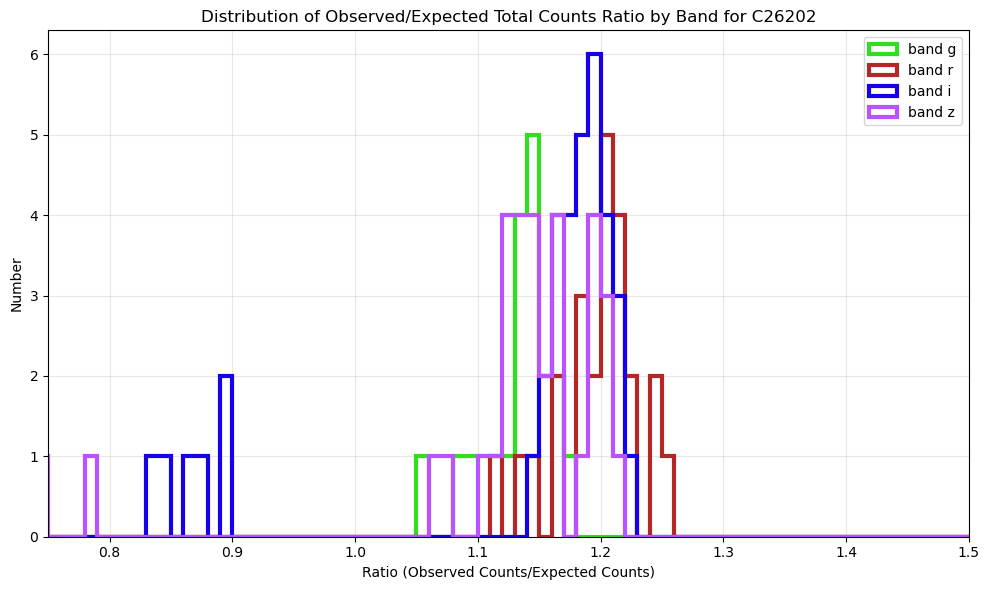

In [56]:
# Based on code retrieved from Claude-3.5-Sonnet and Poe.com Assistant

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors and transparency for each band
colors = plot_filter_colors_white_background
alpha = 1.0   # transparency level
linewidth = 3 # linewidth for the step histogram lines 

# Define bins.  Here, we want to look around ratio=1.00+/-0.20 in steps of 0.01
#bins = np.arange(0.80, 1.20, 0.01)
bins = np.arange(0.00, 2.00, 0.01)

# Plot histogram for each band
for band in flist:
    band_data = best_df[best_df['band'] == band]['ratio_obs_exp']
    if len(band_data) > 0:  # only plot if we have data for this band
        #plt.hist(band_data, bins=bins, alpha=alpha, histtype='step', linewidth=linewidth, 
        #        label=f'band {band}', color=colors[band],
        #        density=False)  # density=True normalizes the area
        #plt.hist(band_data, bins=bins, alpha=alpha, histtype='step', linewidth=linewidth, 
        #        label=f'band {band}', color=filter_colors[band],
        #        linestyle=filter_linestyles[band], 
        #        density=False)  # density=True normalizes the area
        plt.hist(band_data, bins=bins, alpha=alpha, histtype='step', linewidth=linewidth, 
                label=f'band {band}', color=filter_colors[band],
                density=False)  # density=True normalizes the area


plt.xlabel('Ratio (Observed Counts/Expected Counts)')
plt.ylabel('Number')
#plt.xlim([0.75, 1.15])
plt.xlim([0.75, 1.50])
#plt.xlim([0.00, 2.00])

plot_title = """Distribution of Observed/Expected Total Counts Ratio by Band for %s""" % (star_name)
plt.title(plot_title)
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: adjust layout to prevent label clipping
plt.tight_layout()

plt.show()



### 7.3 Print summary statistics for each band

In [57]:
# Based on code retrieved from Claude-3.5-Sonnet

for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    band_data = best_df[best_df['band'] == band]['ratio_obs_exp']
    if len(band_data) > 0:
        print(f"\nBand {band} statistics:")
        print(f"N = {len(band_data)}")
        print(f"Mean = {band_data.mean():.3f}")
        print(f"Median = {band_data.median():.3f}")
        print(f"Std = {band_data.std():.3f}")


Band g statistics:
N = 22
Mean = 1.065
Median = 1.140
Std = 0.224

Band r statistics:
N = 30
Mean = 1.040
Median = 1.196
Std = 0.325

Band i statistics:
N = 36
Mean = 1.134
Median = 1.184
Std = 0.122

Band z statistics:
N = 37
Mean = 1.076
Median = 1.143
Std = 0.183


Let's output a nice table...

In [58]:
# Create empty lists to store the statistics
stats_data = []

for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    band_data = best_df[best_df['band'] == band]['ratio_obs_exp']
    if len(band_data) > 0:
        stats_data.append({
            'band': band,
            'n_band': len(band_data),
            'Mean': f"{band_data.mean():.3f}",
            'Median': f"{band_data.median():.3f}",
            'Std': f"{band_data.std():.3f}"
        })
    else:
        stats_data.append({
            'band': band,
            'n_band': 0,
            'Mean': 'N/A',
            'Median': 'N/A',
            'Std': 'N/A'
        })

# Create DataFrame
stats_df = pd.DataFrame(stats_data)

# Display the table
display(stats_df)
#print(stats_df.to_string(index=False))

,band,n_band,Mean,Median,Std
0,u,0,N/A,N/A,N/A
1,g,22,1.065,1.140,0.224
2,r,30,1.040,1.196,0.325
3,i,36,1.134,1.184,0.122
4,z,37,1.076,1.143,0.183
5,y,0,N/A,N/A,N/A


**Let's stop here for now:**

In [59]:
print("Stopping here...")
raise StopExecution

Stopping here...


## 7. Sandbox

In [ ]:
# Check header of an ISR-corrected exposure image
icExp = butler.get('icExp', dataId=dataId)
icExp_info = icExp.getInfo()
print(icExp_info.getMetadata())
print(dataId)

In [ ]:
# From Lynne Jones...

# Read the file 
seddata = fits.getdata(sedfile)
# Translate to rubin_sim format
wavelen = seddata['WAVELENGTH'] * u.angstrom.to(u.nanometer) # This is in angstroms - need in nanometers
flambda = seddata['FLUX'] / (u.angstrom.to(u.nanometer)) # this is in erg/sec/cm^^2/ang but we want /nm 

defaultDirs = st.setDefaultDirs()
defaultDirs['detector'] = defaultDirs['detector'].replace('/joint_minimum', '/itl')
hardware, system = st.buildHardwareAndSystem(defaultDirs)

sed = pt.Sed(wavelen=wavelen, flambda=flambda)


# exposure time and gain -- gain=1 -> e- counts
phot_params = pt.PhotometricParameters(exptime=30, gain=1, nexp=1)

mags = {}
counts = {}
counts_100k = {}
for f in flist:
    mags[f] = sed.calc_mag(system[f])
    counts[f] = sed.calc_adu(system[f], phot_params)
    counts_100k[f] = counts[f]/100000

#pd.DataFrame([mags, counts, counts_100k], index=['AB mag', 'total counts', 'counts(100k)'])
for f in flist:
    print(f, mags[f], counts[f], counts_100k[f])

In [ ]:
#fgcm_stars = butler.get("fgcm_Cycle5_StandardStars", collections=["u/erykoff/LSSTComCam/DM-47919/highlat/build4/run3"]).asAstropy()

In [ ]:
#fgcm_stars

In [ ]:
#fgcm_stars.write('fgcm_stars.ecsv')

In [ ]:
#from astropy.table import Table
#df_bad_visits=Table.read("https://raw.githubusercontent.com/lsst-dm/excluded_visits/refs/heads/main/LSSTComCam/bad.ecsv").to_pandas()
#df_bad_visits.rename(columns={'exposure': 'visit'}, inplace=True)

In [ ]:
#df_bad_visits

In [ ]:
#best_df[best_df['band'] == band]

In [ ]:
#for colname in best_df.columns:
#    print(colname)

In [ ]:
#best_df['detector'].unique()

In [ ]:
#best_df['id'].unique()

In [ ]:
#best_df[best_df['band']=='u'].plot('visit','ratio_obs_exp', kind='scatter')

In [ ]:
# Based on code retrieved from Claude-3.5-Sonnet and Poe.com Assistant

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors and transparency for each band
colors = plot_filter_colors_white_background
alpha = 1.0   # transparency level

# Plot for each band
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    band_data = best_df[best_df['band'] == band]
    plt.scatter(band_data['visit'], band_data['ratio_obs_exp'], 
                label=f'band {band}', 
                color=plot_filter_colors_white_background[band], 
                alpha=0.7)
    
plt.xlabel('Visit')
plt.ylabel('Ratio (Observed Counts/Expected Counts)')

plt.title('Observed/Expected Total Counts Ratio vs. Visit for C26202')
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: adjust layout to prevent label clipping
plt.tight_layout()

plt.show()



In [ ]:
# Based on code retrieved from Claude-3.5-Sonnet and Poe.com Assistant

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors and transparency for each band
colors = plot_filter_colors_white_background
alpha = 1.0   # transparency level

# Plot for each band
for band in ['u']:
    band_data = best_df[best_df['band'] == band]
    plt.scatter(band_data['detector'], band_data['ratio_obs_exp'], 
                label=f'band {band}', 
                color=plot_filter_colors_white_background[band], 
                alpha=0.7)
    
plt.xlabel('detector')
plt.ylabel('Ratio (Observed Counts/Expected Counts)')

plt.title('Observed/Expected Total Counts Ratio vs. Visit for C26202')
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: adjust layout to prevent label clipping
plt.tight_layout()

plt.show()



In [ ]:
# Based on code retrieved from Claude-3.5-Sonnet and Poe.com Assistant

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors and transparency for each band
colors = plot_filter_colors_white_background
alpha = 1.0   # transparency level

# Plot for each band
for band in ['u']:
    band_data = best_df[best_df['band'] == band]
    plt.scatter(band_data['airmass'], band_data['ratio_obs_exp'], 
                label=f'band {band}', 
                color=plot_filter_colors_white_background[band], 
                alpha=0.7)
    
plt.xlabel('Airmass')
plt.ylabel('Ratio (Observed Counts/Expected Counts)')

plt.title('Observed/Expected Total Counts Ratio vs. Visit for C26202')
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: adjust layout to prevent label clipping
plt.tight_layout()

plt.show()



In [ ]:
best_df['visit']

In [ ]:
df_sci

In [ ]:
merged_df = pd.merge(best_df, df_sci, left_on='visit', right_on='id', how='left')
merged_df

In [ ]:
# Based on code retrieved from Claude-3.5-Sonnet and Poe.com Assistant

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors and transparency for each band
colors = plot_filter_colors_white_background
alpha = 1.0   # transparency level

# Plot for each band
for band in ['u']:
    band_data = merged_df[merged_df['band'] == band]
    plt.scatter(band_data['airmass_y'], band_data['ratio_obs_exp'], 
                label=f'band {band}', 
                color=plot_filter_colors_white_background[band], 
                alpha=0.7)
    
plt.xlabel('Airmass')
plt.ylabel('Ratio (Observed Counts/Expected Counts)')

plt.title('Observed/Expected Total Counts Ratio vs. Visit for C26202')
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: adjust layout to prevent label clipping
plt.tight_layout()

plt.show()


In [ ]:
# Based on code retrieved from Claude-3.5-Sonnet and Poe.com Assistant

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors and transparency for each band
colors = plot_filter_colors_white_background
alpha = 1.0   # transparency level

# Plot for each band
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    band_data = merged_df[merged_df['band'] == band]
    plt.scatter(band_data['mjd'], band_data['ratio_obs_exp'], 
                label=f'band {band}', 
                color=plot_filter_colors_white_background[band], 
                alpha=0.7)
    
plt.xlabel('MJD')
plt.ylabel('Ratio (Observed Counts/Expected Counts)')

plt.title('Observed/Expected Total Counts Ratio vs. Visit for C26202')
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: adjust layout to prevent label clipping
plt.tight_layout()

plt.show()


In [ ]:
# Based on code retrieved from Claude-3.5-Sonnet and Poe.com Assistant

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors and transparency for each band
colors = plot_filter_colors_white_background
alpha = 1.0   # transparency level

# Plot for each band
#for band in ['u', 'g', 'r', 'i', 'z', 'y']:
for band in ['u']:
    band_data = merged_df[merged_df['band'] == band]
    plt.scatter(band_data['expos'], band_data['ratio_obs_exp'], 
                label=f'band {band}', 
                color=plot_filter_colors_white_background[band], 
                alpha=0.7)
    
plt.xlabel('exposure time [sec]')
plt.ylabel('Ratio (Observed Counts/Expected Counts)')

plt.title('Observed/Expected Total Counts Ratio vs. Visit for C26202')
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: adjust layout to prevent label clipping
plt.tight_layout()

plt.show()


In [60]:
repo = 'dp1'
collections = 'LSSTComCam/DP1'
butler = dafButler.Butler(repo, collections=collections)

bp_table = butler.get("standard_passband", instrument="LSSTComCam", band="r")

In [61]:
bp_table

wavelength,throughput
nm,%
float64,float64
300.0,0.0
300.5,0.0
301.0,0.0
301.5,0.0
302.0,0.0
302.5,0.0
303.0,0.0
303.5,0.0


In [62]:
butler.get_known_repos()

{'/repo/aos_imsim',
 '/repo/bts',
 '/repo/dc2',
 '/repo/dc2+sasquatch_dev',
 '/repo/dp1',
 '/repo/dp1_prep',
 '/repo/embargo',
 '/repo/embargo+sasquatch_dev',
 '/repo/embargo.sasquatch_dev',
 '/repo/embargo_new',
 '/repo/embargo_new+sasquatch_dev',
 '/repo/embargo_new.sasquatch_dev',
 '/repo/embargo_old',
 '/repo/embargo_old+sasquatch_dev',
 '/repo/embargo_old.sasquatch_dev',
 '/repo/ir2',
 '/repo/main',
 '/repo/main+sasquatch_dev',
 '/repo/main.sasquatch_dev',
 '/repo/oga',
 '/repo/ops-rehearsal-3-prep',
 '/repo/ops-rehearsal-3-prep+sasquatch_dev',
 '/repo/ops-rehearsal-3-prep.sasquatch_dev',
 '/repo/prompt',
 '/repo/tts',
 '/repo/ucd',
 'LATISS',
 'LSSTCam',
 'LSSTComCam',
 'aos_imsim',
 'bts',
 'dc2',
 'dc2.sasquatch_dev',
 'dp1',
 'dp1_prep',
 'embargo',
 'embargo+sasquatch_dev',
 'embargo.sasquatch_dev',
 'embargo_new',
 'embargo_new+sasquatch_dev',
 'embargo_new.sasquatch_dev',
 'embargo_old',
 'embargo_old+sasquatch_dev',
 'embargo_old.sasquatch_dev',
 'embargo_or4',
 'embargo_o

In [63]:
butler.collections.query_info("LSSTComCam/DP1")

[CollectionInfo(name='LSSTComCam/DP1', type=<CollectionType.CHAINED: 3>, doc='', children=('LSSTComCam/runs/DRP/DP1/DM-51335', 'LSSTComCam/runs/DRP/DP1/v29_0_0/DM-50260', 'LSSTComCam/calib/fgcmcal/DM-48089/standard_passbands'), parents=None, dataset_types=None)]

In [64]:
repo = '/repo/main'
collections = 'LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645'
butler = dafButler.Butler(repo, collections=collections)


In [65]:
butler.collections.query_info('LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645')

[CollectionInfo(name='LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645', type=<CollectionType.CHAINED: 3>, doc='', children=('LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645/20251006T210222Z', 'LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645/20251006T210239Z', 'LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645/20251006T192741Z', 'LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645/20251006T151305Z', 'LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645/20251006T005742Z', 'LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645/20251006T024231Z', 'LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645/20251005T231947Z', 'LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645/20251005T224357Z', 'LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645/20251005T224636Z', 'LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645/20251004T200513Z', 'LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645/20251004T182645Z', 'LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645/2

In [66]:
butler.collections.query_info('LSSTCam/calib/fgcmcal/DM-50154')

[CollectionInfo(name='LSSTCam/calib/fgcmcal/DM-50154', type=<CollectionType.RUN: 1>, doc='', children=(), parents=None, dataset_types=None)]

In [67]:
butler.collections.query_info("LSSTCam/defaults")

[CollectionInfo(name='LSSTCam/defaults', type=<CollectionType.CHAINED: 3>, doc='', children=('LSSTCam/raw/all', 'LSSTCam/calib', 'LSSTCam/calib/unbounded', 'refcats', 'skymaps', 'pretrained_models', 'LSSTCam/calib/fgcmcal'), parents=None, dataset_types=None)]

In [68]:
butler.collections.query_info('LSSTCam/defaults')

[CollectionInfo(name='LSSTCam/defaults', type=<CollectionType.CHAINED: 3>, doc='', children=('LSSTCam/raw/all', 'LSSTCam/calib', 'LSSTCam/calib/unbounded', 'refcats', 'skymaps', 'pretrained_models', 'LSSTCam/calib/fgcmcal'), parents=None, dataset_types=None)]

In [69]:
repo = '/repo/main'
collections = 'LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645'

# List dataset types available in the fgcmcal collection
for dt in butler.registry.queryDatasetTypes():
    if 'fgcm_standard_passband' in dt.name.lower():
        print(dt.name, dt.dimensions)

fgcm_standard_passband {band, instrument, physical_filter}


In [78]:

# Query all physical_filter dimension records for LSSTCam
records = list(
    butler.registry.queryDimensionRecords(
        "physical_filter",
        instrument="LSSTCam"
    )
)

for rec in records:
    print(rec.name, rec.band, rec.instrument)


empty white LSSTCam
u u LSSTCam
g g LSSTCam
r r LSSTCam
i i LSSTCam
z z LSSTCam
y y LSSTCam
unknown unknown LSSTCam
ND_OD0.1 white~nd LSSTCam
ND_OD0.3 white~nd LSSTCam
ND_OD0.5 white~nd LSSTCam
ND_OD0.7 white~nd LSSTCam
ND_OD1.0 white~nd LSSTCam
ND_OD2.0 white~nd LSSTCam
ND_OD0.01 white~nd LSSTCam
ND_OD0.05 white~nd LSSTCam
ND_OD0.4 white~nd LSSTCam
ND_OD3.0 white~nd LSSTCam
ND_OD4.0 white~nd LSSTCam
SDSSu u LSSTCam
SDSSu~ND_OD0.1 u~nd LSSTCam
SDSSu~ND_OD0.3 u~nd LSSTCam
SDSSu~ND_OD0.5 u~nd LSSTCam
SDSSu~ND_OD0.7 u~nd LSSTCam
SDSSu~ND_OD1.0 u~nd LSSTCam
SDSSu~ND_OD2.0 u~nd LSSTCam
SDSSu~ND_OD0.01 u~nd LSSTCam
SDSSu~ND_OD0.05 u~nd LSSTCam
SDSSu~ND_OD0.4 u~nd LSSTCam
SDSSu~ND_OD3.0 u~nd LSSTCam
SDSSu~ND_OD4.0 u~nd LSSTCam
SDSSg g LSSTCam
480nm g LSSTCam
SDSSg~ND_OD0.1 g~nd LSSTCam
SDSSg~ND_OD0.3 g~nd LSSTCam
SDSSg~ND_OD0.5 g~nd LSSTCam
SDSSg~ND_OD0.7 g~nd LSSTCam
SDSSg~ND_OD1.0 g~nd LSSTCam
SDSSg~ND_OD2.0 g~nd LSSTCam
SDSSg~ND_OD0.01 g~nd LSSTCam
SDSSg~ND_OD0.05 g~nd LSSTCam
SDSSg~ND_OD0

In [75]:
repo = '/repo/main'
collections = 'LSSTCam/defaults'
butler = dafButler.Butler(repo, collections=collections)

# List dataset types available in the fgcmcal collection
for dt in butler.registry.queryDatasetTypes():
    if 'fgcm_standard_passband' in dt.name.lower():
        print(dt.name, dt.dimensions)

fgcm_standard_passband {band, instrument, physical_filter}


In [81]:
dataset_type = butler.get_dataset_type('fgcm_standard_passband')
for dimension in dataset_type.dimensions.data_coordinate_keys:
    print('dimension = ', dimension)
    print(butler.dimensions[dimension].schema)
    print(' ')

dimension =  instrument
instrument: 
  name: string
  visit_max: int
    Maximum value for the 'visit' field for visits associated with
    this instrument (exclusive).
  visit_system: int
    The preferred visit system for this instrument.
  exposure_max: int
    Maximum value for the 'exposure' field for exposures associated
    with this instrument (exclusive).
  detector_max: int
    Maximum value for the 'detector' field for detectors associated
    with this instrument (exclusive).
  class_name: string
    Full class name of the Instrument class associated with this
    instrument.
 
dimension =  physical_filter
physical_filter: 
  instrument: string
  name: string
  band: string
 
dimension =  band
band: 
  name: string
 


In [82]:
butler.query_dimension_records('physical_filter')

[physical_filter.RecordClass(instrument='LSSTCam', name='empty', band='white'),
 physical_filter.RecordClass(instrument='LSSTCam', name='u', band='u'),
 physical_filter.RecordClass(instrument='LSSTCam', name='g', band='g'),
 physical_filter.RecordClass(instrument='LSSTCam', name='r', band='r'),
 physical_filter.RecordClass(instrument='LSSTCam', name='i', band='i'),
 physical_filter.RecordClass(instrument='LSSTCam', name='z', band='z'),
 physical_filter.RecordClass(instrument='LSSTCam', name='y', band='y'),
 physical_filter.RecordClass(instrument='LSSTCam', name='unknown', band='unknown'),
 physical_filter.RecordClass(instrument='LSSTCam', name='ND_OD0.1', band='white~nd'),
 physical_filter.RecordClass(instrument='LSSTCam', name='ND_OD0.3', band='white~nd'),
 physical_filter.RecordClass(instrument='LSSTCam', name='ND_OD0.5', band='white~nd'),
 physical_filter.RecordClass(instrument='LSSTCam', name='ND_OD0.7', band='white~nd'),
 physical_filter.RecordClass(instrument='LSSTCam', name='ND_

In [80]:
standard_r = butler.get('fgcm_standard_passband', band='r', instrument='LSSTCam', physical_filter='r')

DatasetNotFoundError: Dataset fgcm_standard_passband with data ID {instrument: 'LSSTCam', physical_filter: 'r', band: 'r'} could not be found in collections ('LSSTCam/defaults',).

In [85]:
butler.query_data_ids('band')

[{band: 'g~nd'},
 {band: 'grid'},
 {band: 'N718'},
 {band: '275CutOn'},
 {band: 'N973'},
 {band: 'grid~nd'},
 {band: 'streak'},
 {band: 'spot~nd'},
 {band: 'SH'},
 {band: 'notch'},
 {band: 'y~nd'},
 {band: 'r'},
 {band: 'N1010'},
 {band: 'g'},
 {band: 'I945'},
 {band: 'N515'},
 {band: 'spot'},
 {band: 'diffuser'},
 {band: 'u'},
 {band: 'i~nd'},
 {band: 'i'},
 {band: 'PH'},
 {band: 'N527'},
 {band: 'N964'},
 {band: 'white'},
 {band: 'opaque'},
 {band: 'z'},
 {band: 'z~nd'},
 {band: 'N921'},
 {band: 'sparsegrid'},
 {band: 'unknown'},
 {band: 'sparsegrid~nd'},
 {band: 'white~nd'},
 {band: 'OG590'},
 {band: 'ellipses'},
 {band: '550CutOn'},
 {band: 'N816'},
 {band: 'N400'},
 {band: 'N926'},
 {band: 'N468'},
 {band: 'streak~nd'},
 {band: 'u~nd'},
 {band: 'N387'},
 {band: 'y'},
 {band: 'VR'},
 {band: 'N656'},
 {band: 'ellipses~nd'},
 {band: 'r~nd'}]

In [88]:
#butler.query_dimension_records("tract")

In [76]:
dataset_refs = butler.query_datasets("fgcm_standard_passband")

EmptyQueryResultError: Possible reasons for empty result:
Search for dataset type 'fgcm_standard_passband' in ['LSSTCam/defaults'] is doomed to fail.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/raw/all'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52754/3s_v1_rc2_interim/flat-y.20251003b'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52754/3s_v1_rc2_interim/flat-z.20251003b'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52754/3s_v1_rc2_interim/flat-i.20251003b'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52754/3s_v1_rc2_interim/flat-r.20251003b'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52754/3s_v1_rc2_interim/flat-g.20251003b'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52754/3s_v1_rc2_interim/flat-u.20251003b'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52754/3s_v1_rc2_interim/dark.20251003b'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52754/3s_v1_rc2_interim/bias.20251003b'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52754/3s_v1_rc2_interim/ptc.20251003b'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52754/3s_v1_rc2_interim/linearizer.20251003a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52727/flats-2s-v30-dp2/flat-y.20251006a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52727/flats-2s-v30-dp2/flat-z.20251006a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52727/flats-2s-v30-dp2/flat-i.20251006a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52727/flats-2s-v30-dp2/flat-r.20251006a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52727/flats-2s-v30-dp2/flat-g.20251006a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52727/flats-2s-v30-dp2/flat-u.20251006a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52726/ref-sky-radial-gradient-dp2/flatGradientReference-y.20251002a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52726/ref-sky-radial-gradient-dp2/flatGradientReference-z.20251002a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52726/ref-sky-radial-gradient-dp2/flatGradientReference-i.20251002a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52726/ref-sky-radial-gradient-dp2/flatGradientReference-r.20251002a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52726/ref-sky-radial-gradient-dp2/flatGradientReference-g.20251002a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52726/ref-sky-radial-gradient-dp2/flatGradientReference-u.20251002a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50151/astrometry_camera/astrometry_camera-u.20250914a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50151/astrometry_camera/astrometry_camera-g.20250914a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50151/astrometry_camera/astrometry_camera-r.20250914a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50151/astrometry_camera/astrometry_camera-i.20250914a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50151/astrometry_camera/astrometry_camera-z.20250914a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50151/astrometry_camera/astrometry_camera-y.20250914a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51897/3s_v1/flat-y.20250814a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51897/3s_v1/flat-z.20250814a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51897/3s_v1/flat-i.20250814a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51897/3s_v1/flat-r.20250814a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51897/3s_v1/flat-g.20250814a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51897/3s_v1/flat-u.20250814a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51897/3s_v1/dark.20250814a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51897/3s_v1/bias.20250808a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51897/3s_v1/cti.20250808a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51897/3s_v1/bfk.20250808a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51897/3s_v1/ptc.20250808a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51897/3s_v1/linearizer.20250808a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51432/ref-sky-radial-gradient-ugrizy/flatGradientReference-y.20250812a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51432/ref-sky-radial-gradient-ugrizy/flatGradientReference-z.20250812a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51432/ref-sky-radial-gradient-ugrizy/flatGradientReference-i.20250812a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51432/ref-sky-radial-gradient-ugrizy/flatGradientReference-r.20250812a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51432/ref-sky-radial-gradient-ugrizy/flatGradientReference-g.20250812a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51432/ref-sky-radial-gradient-ugrizy/flatGradientReference-u.20250812a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52163/flats-2s-v30-nograd-ugrizy/flat-y.20250812a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52163/flats-2s-v30-nograd-ugrizy/flat-z.20250812a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52163/flats-2s-v30-nograd-ugrizy/flat-i.20250812a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52163/flats-2s-v30-nograd-ugrizy/flat-r.20250812a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52163/flats-2s-v30-nograd-ugrizy/flat-g.20250812a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-52163/flats-2s-v30-nograd-ugrizy/flat-u.20250812a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50904/izy-flats-20250515/flat-y.20250515a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50904/izy-flats-20250515/flat-z.20250515a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50904/izy-flats-20250515/flat-i.20250515a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50736/onSkyDefects/defects.20250506a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50630/ugri-flats-20250501/flat-i.20250501a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50630/ugri-flats-20250501/flat-r.20250501a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50630/ugri-flats-20250501/flat-g.20250501a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50630/ugri-flats-20250501/flat-u.20250501a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50448/initial-ugri-flats/flat-i.20250424a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50448/initial-ugri-flats/flat-r.20250424a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50448/initial-ugri-flats/flat-g.20250424a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50448/initial-ugri-flats/flat-u.20250424a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50336/run7/ptc.20250423a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50295/initial-i-flat/flat-i.20250420a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-50162/pseudoFlats/pseudoFlat.20250414b'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-49175/run7/dark.20250320a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-49175/run7/bias.20250320a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-49175/run7/cti.20250320a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-49175/run7/bfk.20250320a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-49175/run7/ptc.20250320a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-49175/run7/linearizer.20250320a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-49175/run7/defects.20250401a'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-49679/pseudoFlats/pseudoFlat.20250401b'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51669'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/DM-51669/unbounded'.
No datasets of type 'fgcm_standard_passband' in collection 'refcats/DM-28636'.
No datasets of type 'fgcm_standard_passband' in collection 'refcats/DM-33444'.
No datasets of type 'fgcm_standard_passband' in collection 'refcats/DM-39298'.
No datasets of type 'fgcm_standard_passband' in collection 'refcats/DM-46370/the_monster_20240904'.
No datasets of type 'fgcm_standard_passband' in collection 'refcats/DM-49042/the_monster_20250219'.
No datasets of type 'fgcm_standard_passband' in collection 'skymaps'.
No datasets of type 'fgcm_standard_passband' in collection 'pretrained_models/tac_cnn_comcam_2025-02-18'.
No datasets of type 'fgcm_standard_passband' in collection 'LSSTCam/calib/fgcmcal/DM-50154'.

In [71]:
refs = list(
    butler.registry.queryDatasets(
        "fgcm_standard_passband",
        collections="LSSTCam/calib/fgcmcal/DM-50154"
    )
)

for ref in refs:
    print(ref.dataId, ref.run)


In [72]:
datasets = list(
    butler.registry.queryDatasets(
        datasetType="fgcm_standard_passband"
    )
)

for ds in datasets:
    print(ds)


In [73]:
help(butler.registry)

Help on RegistryShim in module lsst.daf.butler._registry_shim object:

class RegistryShim(lsst.daf.butler.registry._registry.Registry)
 |  RegistryShim(butler: 'DirectButler')
 |
 |  Implementation of `Registry` interface exposed to clients by `Butler`.
 |
 |  Parameters
 |  ----------
 |  butler : `DirectButler`
 |      Data butler instance.
 |
 |  Notes
 |  -----
 |  This shim implementation of `Registry` forwards all methods to an actual
 |  Registry instance which is internal to Butler or to Butler methods. Its
 |  purpose is to provide a stable interface to many client-visible operations
 |  while we perform re-structuring of Registry and Butler implementations.
 |
 |  Method resolution order:
 |      RegistryShim
 |      lsst.daf.butler.registry._registry.Registry
 |      abc.ABC
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  __init__(self, butler: 'DirectButler')
 |      Initialize self.  See help(type(self)) for accurate signature.
 |
 |  associate(self, collection